# **Evaluation of OOI Nitrate Sensors **

*Liz Suter, July-Aug 2018*
## **Review Summary**
My goals with this review are:

1- Compare ISUS to SUNA sensors. We know that SUNA sensors have less biofouling issues ans the ISUS sensors are discontinued but are the ISUS sensor useable?

2 - Determine whether expected interannual patterns in NO3 are captured but the SUNA sensors.

3 - **Science Question**: Does high resolution NO3 densor data allow for detection of NO3 from upwelling in surface waters? Or is phytoplankton uptake so rapid that nutrient concentrations always remain low? I will attempt to compare NO3 to phytoplankton proxies to determine if the dynamics between nutrients and plankton makes sense.


In [1]:
USERNAME = ''
TOKEN =  ''

In [2]:
import requests
import datetime
import time
import re
import os
import xarray as xr
import netCDF4 as nc
import json
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import gc
from bokeh.plotting import figure, output_file, reset_output, show, ColumnDataSource, save
from bokeh.models import BoxAnnotation
from bokeh.io import output_notebook
import numpy as np


## **1- Comparison of ISUS and SUNA sensors**

### A) **Coastal Endurance, Oregon Offshore Surface Mooring, Near Surface Instrument Frame (CE04OSSM)**
*This site was using ISUS (NUTNR-B) from it's begining in 2015 until most recent dataset*

In [4]:
# Instrument Information 
# CE04OSSM-RID26-07-NUTNRB000

site = 'CE04OSSM'
node = 'RID26'
instrument = '07-NUTNRB000'
method = 'recovered_inst'
stream = 'nutnr_b_instrument_recovered'

VOCAB_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
request_url ='/'.join((VOCAB_BASE_URL,site,node,instrument)) # Python wizard best



# Retrieve vocabulary information 
r = requests.get(request_url, auth=(USERNAME, TOKEN))
data = r.json() #this converts from json back to python array
data

[{'@class': '.VocabRecord',
  'model': 'ISUS',
  'manufacturer': 'Satlantic',
  'vocabId': 161,
  'refdes': 'CE04OSSM-RID26-07-NUTNRB000',
  'instrument': 'Nitrate',
  'tocL1': 'Coastal Endurance',
  'tocL2': 'Oregon Offshore Surface Mooring',
  'tocL3': 'Near Surface Instrument Frame',
  'mindepth': 7.0,
  'maxdepth': 7.0}]

In [5]:
# Retrieve data

# API base url
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Request URL
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

params = {
  'beginDT':'2013-01-01T00:00:00.000Z',
  'endDT':'2018-08-10T00:00:00.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}


In [6]:
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()
# print(data['allURLs'][0])

In [7]:
url ='https://opendap.oceanobservatories.org/thredds/catalog/ooi/elizabeth.suter@wagner.edu/20180803T024123-CE04OSSM-RID26-07-NUTNRB000-recovered_inst-nutnr_b_instrument_recovered/catalog.html'

In [8]:
# # Use to monitor data download- Comment out when not downloading data
# check_complete = data['allURLs'][1] + '/status.txt'
# for i in range(1800):
#     r = requests.get(check_complete)
#     if r.status_code == requests.codes.ok:
#         print('request completed')
#         break
#     else:
#             time.sleep(1)

In [9]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
# datasets

In [11]:
# Create a list of only the NUTNR files 
# (exclude files from CTD that might also be provided in the data request)
datasets_sel = []
for i in datasets:
    if '03-CTDBPC000' in i:
        pass
    else:
        datasets_sel.append(i)
datasets_sel

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/elizabeth.suter@wagner.edu/20180803T024123-CE04OSSM-RID26-07-NUTNRB000-recovered_inst-nutnr_b_instrument_recovered/deployment0004_CE04OSSM-RID26-07-NUTNRB000-recovered_inst-nutnr_b_instrument_recovered_20170421T020026-20171013T160031.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/elizabeth.suter@wagner.edu/20180803T024123-CE04OSSM-RID26-07-NUTNRB000-recovered_inst-nutnr_b_instrument_recovered/deployment0002_CE04OSSM-RID26-07-NUTNRB000-recovered_inst-nutnr_b_instrument_recovered_20160516T050031-20161001T150043.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/elizabeth.suter@wagner.edu/20180803T024123-CE04OSSM-RID26-07-NUTNRB000-recovered_inst-nutnr_b_instrument_recovered/deployment0001_CE04OSSM-RID26-07-NUTNRB000-recovered_inst-nutnr_b_instrument_recovered_20150407T230033-20160509T143043.nc']

In [ ]:
# Load the data files
ds = xr.open_mfdataset(datasets_sel)
# ds

In [ ]:
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds = ds.swap_dims({'obs': 'time'}) 

# Sort the data
ds = ds.sortby('time'); 

# Optional, this is used to optimize data processing
ds = ds.chunk({'time': 100}) 

ds

### Check annotations

In [14]:
# Specify a reference designator
refdes = 'CE04OSSM-RID26-07-NUTNRB000'
begin = int(datetime.date(2013,1,1).strftime('%s'))*1000
end = int(datetime.datetime.now().strftime("%s")) * 1000 # current date

In [15]:
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT': begin,
  'endDT': end,
  'refdes': refdes,
}

# Send the request
r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

# Also make a pandas variable from annotation data so for use later in plotting
anno_data = pd.read_json(json.dumps(r.json())) # convert json response to pandas dataframe

In [16]:
# convert timestamps to readable
def convert_time(ms):
    if ms != None:
        return datetime.datetime.utcfromtimestamp(ms/1000)
    else:
        return None

In [ ]:
# Convert info the json response to a dataframe for easier visualization
df = pd.DataFrame()
for d in data:
    df = df.append({
        'annotation_id': d['id'],
        'subsite': d['subsite'],
        'node': d['node'],
        'sensor': d['sensor'],
        'stream': d['stream'],
        'method': d['method'],
        'start': convert_time(d['beginDT']),
        'stop': convert_time(d['endDT']),
        'qcFlag': d['qcFlag'],
        'annotation': d['annotation']
    }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
# df.head()


In [18]:
# Write annotations to a csv file in working directory
df.to_csv('{}_annotations.csv'.format(refdes), index=False)
# exports annotations as csv. Shows up in working directory

In [19]:
for i in range(len((anno_data['annotation'].values))):
    print(i)
    print(anno_data['annotation'].iloc[i])
    print('start time:', anno_data['beginDT'].iloc[i])
    print('end time:', anno_data['endDT'].iloc[i],'\n')

0
Instrument not deployed during Fall 2016 cruise because its refurbishment was not complete before the cruise.

start time: 1475280000000
end time: 1493596800000.0 

1
The NUTNR on the NSIF for CE04OSSM is starting to show signs of biofouling (beginning on approximately 2015-11-29). Nitrogen data (NITROPT) from this date forward for the CE04OSSM-00001 deployment should be looked at carefully and considered as suspect.
start time: 1448755200000
end time: 1462752000000.0 

2
Data goes from ~50 umol/L to -200 umol/L in a matter of hours. Probably an instrument failure
start time: 1455667200000
end time: 1462752000000.0 

3
The Satlantic ISUS instrument has been discontinued, and all OOI ISUS units have been converted to the Sea-Bird SUNA model. A new data parser is in development, and any resulting data gaps will be filled once the parser has been delivered and the data are processed.
start time: 1522780221000
end time: nan 



### Plot Timeseries of NO3

In [20]:
import seaborn as sns
sns.set()

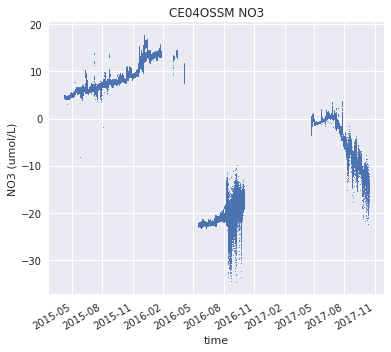

In [21]:
# Scatterplot of NO3
fig,ax1 = plt.subplots(1,1,figsize=(6,5))
ds['salinity_corrected_nitrate'].plot(ax=ax1,label='Raw',linestyle='None',marker='.',markersize=2)
ax1.set_ylabel('NO3 (umol/L)')
ax1.set_title('CE04OSSM NO3');

plt.savefig('CE04OSSM_NO3.png');

### Summary
Jumps in sensors clearly make these data difficult to use. But range/ pattern over time may be real...

### **B)Comparison of CE01ISSM-RID16-07-NUTNRB000 [Coastal Endurance Oregon Inshore Surface Mooring - Near Surface Instrument Frame - ISUS] and CE01ISSP-SP001-06-NUTNRJ000 [Coastal Endurance Oregon Inshore Surface Piercing Profiler Mooring - SUNA]**


In [23]:
# Instrument 1 Information 
# CE01ISSM-RID16-07-NUTNRB000

site = 'CE01ISSM'
node = 'RID16'
instrument = '07-NUTNRB000'
method = 'recovered_inst'
stream = 'nutnr_b_instrument_recovered'

VOCAB_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
request_url ='/'.join((VOCAB_BASE_URL,site,node,instrument)) # Python wizard best

# Retrieve vocabulary information for a given instrument
r = requests.get(request_url, auth=(USERNAME, TOKEN))
data = r.json() #this converts from json back to python array
data

[{'@class': '.VocabRecord',
  'model': 'ISUS',
  'manufacturer': 'Satlantic',
  'vocabId': 27,
  'refdes': 'CE01ISSM-RID16-07-NUTNRB000',
  'instrument': 'Nitrate',
  'tocL1': 'Coastal Endurance',
  'tocL2': 'Oregon Inshore Surface Mooring',
  'tocL3': 'Near Surface Instrument Frame',
  'mindepth': 7.0,
  'maxdepth': 7.0}]

In [25]:
# API base url
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Create the request URL- similar to above
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# All of the following are optional but if you don't specify dates, you will get entire datasets. For some sets, this is enormous.- Include parameters- Last 2 lines are optional
params = {
  'beginDT':'2013-01-01T00:00:00.000Z',
  'endDT':'2018-08-10T00:00:00.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}

In [26]:
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()
# print(data['allURLs'][0])

In [27]:
url ='https://opendap.oceanobservatories.org/thredds/catalog/ooi/elizabeth.suter@wagner.edu/20180803T113125-CE01ISSM-RID16-07-NUTNRB000-recovered_inst-nutnr_b_instrument_recovered/catalog.html'

In [28]:
# # Use to monitor data download- Comment out when not downloading data
# check_complete = data['allURLs'][1] + '/status.txt'
# for i in range(1800):
#     r = requests.get(check_complete)
#     if r.status_code == requests.codes.ok:
#         print('request completed')
#         break
#     else:
#             time.sleep(1)

In [ ]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
# datasets

In [30]:
# Create a list of only the NUTNR files 
# (exclude files from CTD that might also be provided in the data request)
datasets_sel = []
for i in datasets:
    if '03-CTDBPC000' in i:
        pass
    else:
        datasets_sel.append(i)
# datasets_sel

In [31]:
# Load the data files
ds = xr.open_dataset(datasets_sel[1])

# CANNOT OPEN ALL DATASETS. ERROR WITH REPLICATE INDEXES IN OBS
# ALSO PROBLEM WHEN PLOTTING BECAUSE AFTER CONVERTING DEFAULT AXIS TO TIME, IT IS GIVING ME THIS ERROR:
# "ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units"

In [ ]:
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds = ds.swap_dims({'obs': 'time'}) 

# Sort the data
ds = ds.sortby('time'); 

# Optional, this is used to optimize data processing
ds = ds.chunk({'time': 100}) 

#ds

### Check annotations

In [57]:
# Specify a reference designator
refdes = 'CE01ISSM-RID16-07-NUTNRB000'

begin = int(datetime.date(2013,1,1).strftime('%s'))*1000
end = int(datetime.datetime.now().strftime("%s")) * 1000 # current date

In [35]:
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT': begin,
  'endDT': end,
  'refdes': refdes,
}

# Send the request
r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

# Also make a pandas variable from annotation data so for use later in plotting
anno_data = pd.read_json(json.dumps(r.json())) # convert json response to pandas dataframe

In [36]:
# convert timestamps to readable
def convert_time(ms):
    if ms != None:
        return datetime.datetime.utcfromtimestamp(ms/1000)
    else:
        return None

In [ ]:
# Convert info the json response to a dataframe for easier visualization
df = pd.DataFrame() # Setup empty array
for d in data:
    df = df.append({
        'annotation_id': d['id'],
        'subsite': d['subsite'],
        'node': d['node'],
        'sensor': d['sensor'],
        'stream': d['stream'],
        'method': d['method'],
        'start': convert_time(d['beginDT']),
        'stop': convert_time(d['endDT']),
        'qcFlag': d['qcFlag'],
        'annotation': d['annotation']
    }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df.head()
# view annotation in human readable. These are listed in no particular order. Look at all levels for annotations (node, sensor, stream, subsite, etc)

In [38]:
# Write annotations to a csv file in working directory
df.to_csv('{}_annotations.csv'.format(refdes), index=False)
# exports annotations as csv. Shows up in working directory

In [39]:
for i in range(len((anno_data['annotation'].values))):
    print(i)
    print(anno_data['annotation'].iloc[i])
    print('start time:', anno_data['beginDT'].iloc[i])
    print('end time:', anno_data['endDT'].iloc[i],'\n')

0
All of the inshore surface moorings suffer from an issue called the 'top of the day problem.' 

A race condition exists in the CPM firmware when transferring daily log files harvested from the various sub-components in a buoy system (e.g. DCL16, CPM3, DCL35, etc) over the Iridium RUDICS connection. The primary CPM rsync's data files from the various sub-components to a central data directory. The first time a daily file is created/copied into that directory (usually shortly after midnight), a compressed copy of the file is created and that compressed file is queued up in a separate text file for transmission to shore. The transfer routine reads that text file and processes the files from that list in order from top to bottom.

Once that compressed file is transferred to shore, no further updates for that file are sent to shore. Meanwhile, the CPM continues to rsync data from the different sub-components, updating the original daily log file.

The net result is that data is accumulati

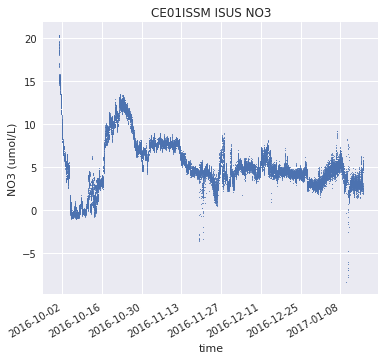

In [40]:
# Scatterplot of NO3
fig,ax1 = plt.subplots(1,1,figsize=(6,5))
ds['salinity_corrected_nitrate'].plot(ax=ax1,label='Raw',linestyle='None',marker='.',markersize=2)
ax1.set_ylabel('NO3 (umol/L)')
ax1.set_title('CE01ISSM ISUS NO3');

plt.savefig('CE01ISSM_NUTNRB000_NO3.png');

In [41]:
# Instrument 2 Information 
# CE01ISSP-SP001-06-NUTNRJ000

site = 'CE01ISSP'
node = 'SP001'
instrument = '06-NUTNRJ000'
method = 'recovered_cspp'
stream = 'nutnr_j_cspp_instrument_recovered'

VOCAB_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
request_url ='/'.join((VOCAB_BASE_URL,site,node,instrument)) # Python wizard best

# Retrieve vocabulary information for a given instrument
r = requests.get(request_url, auth=(USERNAME, TOKEN))
data = r.json() #this converts from json back to python array
data

[{'@class': '.VocabRecord',
  'model': 'SUNA V2',
  'manufacturer': 'Satlantic',
  'vocabId': 43,
  'refdes': 'CE01ISSP-SP001-06-NUTNRJ000',
  'instrument': 'Nitrate',
  'tocL1': 'Coastal Endurance',
  'tocL2': 'Oregon Inshore Surface Piercing Profiler Mooring',
  'tocL3': 'Surface Piercing Profiler',
  'mindepth': 0.0,
  'maxdepth': 25.0}]

Data Requests:

In [113]:
# Instrument  
# CE01ISSP-SP001-06-NUTNRJ000

# API base url
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Create the request URL- similar to above
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# All of the following are optional but if you don't specify dates, you will get entire datasets. For some sets, this is enormous.- Include parameters- Last 2 lines are optional
params = {
  'beginDT':'2013-01-01T00:00:00.000Z',
  'endDT':'2018-08-10T00:00:00.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}


In [42]:
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()
# print(data['allURLs'][0])

In [43]:
url ='https://opendap.oceanobservatories.org/thredds/catalog/ooi/elizabeth.suter@wagner.edu/20180803T115259-CE01ISSP-SP001-06-NUTNRJ000-recovered_cspp-nutnr_j_cspp_instrument_recovered/catalog.html'

In [44]:
# # Use to monitor data download- Comment out when not downloading data
# check_complete = data['allURLs'][1] + '/status.txt'
# for i in range(1800):
#     r = requests.get(check_complete)
#     if r.status_code == requests.codes.ok:
#         print('request completed')
#         break
#     else:
#             time.sleep(1)

In [ ]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
# datasets

In [ ]:
# Create a list of only the NUTNR files 
# (exclude files from CTD that might also be provided in the data request)
datasets_sel = []
for i in datasets:
    if '09-CTDPFJ000' in i:
        pass
    else:
        datasets_sel.append(i)
datasets_sel

In [47]:
# Load the data files
ds = xr.open_mfdataset(datasets_sel[2:4])

# Choose datasets to match up with graph above

# This results in a reduce error that I don't understand:

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


In [ ]:
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds = ds.swap_dims({'obs': 'time'}) 

# Sort the data
ds = ds.sortby('time'); 

# Optional, this is used to optimize data processing
ds = ds.chunk({'time': 100}) 

# ds

### Check annotations

In [50]:
# Specify a reference designator
refdes = 'CE01ISSP-SP001-06-NUTNRJ000'

begin = int(datetime.date(2013,1,1).strftime('%s'))*1000
end = int(datetime.datetime.now().strftime("%s")) * 1000 # current date

In [51]:
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT': begin,
  'endDT': end,
  'refdes': refdes,
}

# Send the request
r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

# Also make a pandas variable from annotation data so for use later in plotting
anno_data = pd.read_json(json.dumps(r.json())) # convert json response to pandas dataframe

In [52]:
# convert timestamps to readable
def convert_time(ms):
    if ms != None:
        return datetime.datetime.utcfromtimestamp(ms/1000)
    else:
        return None

In [53]:
# Convert info the json response to a dataframe for easier visualization
df = pd.DataFrame() # Setup empty array
for d in data:
    df = df.append({
        'annotation_id': d['id'],
        'subsite': d['subsite'],
        'node': d['node'],
        'sensor': d['sensor'],
        'stream': d['stream'],
        'method': d['method'],
        'start': convert_time(d['beginDT']),
        'stop': convert_time(d['endDT']),
        'qcFlag': d['qcFlag'],
        'annotation': d['annotation']
    }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df.head()
# view annotation in human readable. These are listed in no particular order. Look at all levels for annotations (node, sensor, stream, subsite, etc)

""


In [55]:
# Write annotations to a csv file in working directory
df.to_csv('{}_annotations.csv'.format(refdes), index=False)
# exports annotations as csv. Shows up in working directory

## NO ANNOTATIONS FOR THIS DATASET even though there are long gaps in record

### Plot Timeseries of NO3

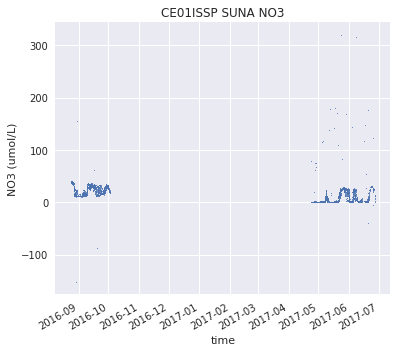

In [56]:
# Scatterplot of NO3
fig,ax1 = plt.subplots(1,1,figsize=(6,5))
ds['salinity_corrected_nitrate'].plot(ax=ax1,label='Raw',linestyle='None',marker='.',markersize=2)
ax1.set_ylabel('NO3 (umol/L)')
ax1.set_title('CE01ISSP SUNA NO3');

plt.savefig('CE01ISSP_NUTNRJ000_NO3.png');

### Summary
- Isus sensor at CE01ISSM is well annotated. Sometimes gives negative data but I don't see unrealistic patterns. But I could not open all deployment files because of an error with replicate indices in the OBS variable.
- SUNA sensor at CE01ISSP is not annotated despite large data gaps. There are also large fluctuations in NO3 data that are likely not real (up to 200-300 umol/kg)
- Fluctuations in the ISIS and SUNA sensors seem similar

## **2- Assessment of interannual patterns in nutrients using profiler data**

There are 3 profilers with DEEP SUNA sensors that I will assess:  
A) CE04OSPS-SF01B-4A-NUTNRA102   
B) RS01SBPS-SF01A-4A-NUTNRA101  
C) RS03AXPS-SF03A-4A-NUTNRA301

### **A) Oregon Offshore Cabled Shallow Profiler Mooring (CE04OSPS)**
CE04OSPS-SF01B-4A-NUTNRA102  
20 to 200 meters  
Shallow Profiler (SF01B)  
Nitrate (NUTNRA)  
Satlantic - Deep SUNA  

In [59]:
# Instrument Information 
# CE04OSPS-SF01B-4A-NUTNRA102

site = 'CE04OSPS'
node = 'SF01B'
instrument = '4A-NUTNRA102'
method = 'streamed'
stream = 'nutnr_a_sample'

VOCAB_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
request_url ='/'.join((VOCAB_BASE_URL,site,node,instrument)) # Python wizard best

# Retrieve vocabulary information for a given instrument
r = requests.get(request_url, auth=(USERNAME, TOKEN))
data = r.json() #this converts from json back to python array
data

[{'@class': '.VocabRecord',
  'model': 'Deep SUNA',
  'manufacturer': 'Satlantic',
  'vocabId': 150,
  'refdes': 'CE04OSPS-SF01B-4A-NUTNRA102',
  'instrument': 'Nitrate',
  'tocL1': 'Coastal Endurance',
  'tocL2': 'Oregon Offshore Cabled Shallow Profiler Mooring',
  'tocL3': 'Shallow Profiler (SF01B)',
  'mindepth': 20.0,
  'maxdepth': 200.0}]

### Data Request:

In [60]:
# API base url
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Create the request URL- similar to above
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# All of the following are optional but if you don't specify dates, you will get entire datasets. For some sets, this is enormous.- Include parameters- Last 2 lines are optional
params = {
  'beginDT':'2013-01-01T00:00:00.000Z',
  'endDT':'2018-08-10T00:00:00.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}

In [61]:
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()
# print(data['allURLs'][0])

In [62]:
url ='https://opendap.oceanobservatories.org/thredds/catalog/ooi/elizabeth.suter@wagner.edu/20180801T173829-CE04OSPS-SF01B-4A-NUTNRA102-streamed-nutnr_a_sample/catalog.html'

In [63]:
# Use to monitor data download- Comment out when not downloading data
# check_complete = data['allURLs'][1] + '/status.txt'
# for i in range(1800):
#     r = requests.get(check_complete)
#     if r.status_code == requests.codes.ok:
#         print('request completed')
#         break
#     else:
#             time.sleep(1)

In [64]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
# datasets

In [65]:
# Create a list of only the NUTNR files 
# (exclude files from CTD that might also be provided in the data request)
datasets_sel = []
for i in datasets:
    if '2A-CTDPFA107' in i:
        pass
    else:
        datasets_sel.append(i)
# datasets_sel

In [ ]:
# Load the data files
ds = xr.open_mfdataset(datasets_sel[0:3])
# ds

# NOTE I am skipping last file because of missing coordinates attribute

### Check annotations 

In [67]:
# Specify a reference designator
refdes = 'CE04OSPS-SF01B-4A-NUTNRA102'

begin = int(datetime.date(2013,1,1).strftime('%s'))*1000
end = int(datetime.datetime.now().strftime("%s")) * 1000 # current date

In [68]:
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT': begin,
  'endDT': end,
  'refdes': refdes,
}

# Send the request
r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

# Also make a pandas variable from annotation data so for use later in plotting
anno_data = pd.read_json(json.dumps(r.json())) # convert json response to pandas dataframe

In [69]:
# convert timestamps to readable
def convert_time(ms):
    if ms != None:
        return datetime.datetime.utcfromtimestamp(ms/1000)
    else:
        return None

In [ ]:
# Convert info the json response to a dataframe for easier visualization
df = pd.DataFrame() # Setup empty array
for d in data:
    df = df.append({
        'annotation_id': d['id'],
        'subsite': d['subsite'],
        'node': d['node'],
        'sensor': d['sensor'],
        'stream': d['stream'],
        'method': d['method'],
        'start': convert_time(d['beginDT']),
        'stop': convert_time(d['endDT']),
        'qcFlag': d['qcFlag'],
        'annotation': d['annotation']
    }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
# df.head()
# view annotation in human readable. These are listed in no particular order. Look at all levels for annotations (node, sensor, stream, subsite, etc)

In [71]:
# Write annotations to a csv file in working directory
df.to_csv('{}_annotations.csv'.format(refdes), index=False)
# exports annotations as csv. Shows up in working directory

In [72]:
for i in range(len((anno_data['annotation'].values))):
    print(i)
    print(anno_data['annotation'].iloc[i])
    print('start time:', anno_data['beginDT'].iloc[i])
    print('end time:', anno_data['endDT'].iloc[i],'\n')

0
On Saturday, September 16, 2017 at around 12:15 GMT, the CA Shallow Profiler at Endurance (CE04OSPS) went offline due to an overcurrent power event. Initial investigation indicated external aggression on one of the two anchor legs, pulling the platform that is normally fixed at 200m below the surface to 400m, and then rose to 100m before communications were lost. No data products are expected from CE04OSPS until the platform is re-deployed. For more information, please contact help@oceanobservatories.org
start time: 1505564021000
end time: nan 

1
Data are suspect during this time range, due to the following event: On Saturday, September 16, 2017 at around 12:15 GMT, the CA Shallow Profiler at Endurance (CE04OSPS) went offline due to an overcurrent power event. Initial investigation indicated external aggression on one of the two anchor legs, pulling the platform that is normally fixed at 200m below the surface to 400m, and then rose to 100m before communications were lost. No data p

### Plot Timeseries of NO3 from Mooring

In [ ]:
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds = ds.swap_dims({'obs': 'time'}) 

# Sort the data
ds = ds.sortby('time'); 

# Optional, this is used to optimize data processing
ds = ds.chunk({'time': 100}) 

# ds

In [75]:
# Extract the values individually so you can crete multi-D scatter plots
dtime = ds['time'].values
pressure = ds['int_ctd_pressure'].values
temperature = ds['seawater_temperature'].values
salinity = ds['practical_salinity'].values
no3 = ds['salinity_corrected_nitrate'].values

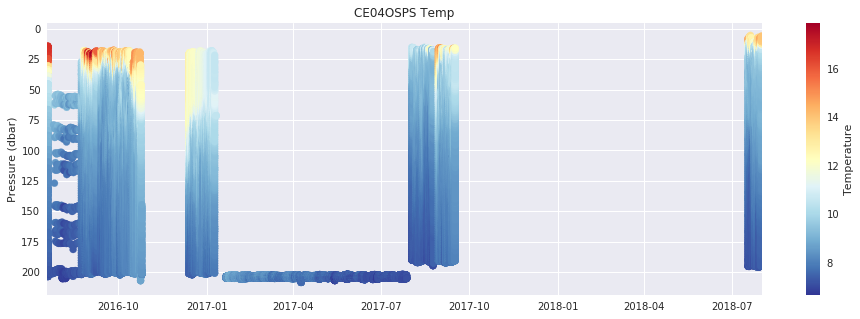

In [76]:
# Scatterplot of Temp
fig,ax1 = plt.subplots(1,1,figsize=(16,5))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap='RdYlBu_r') # Add s=2 to set the markersize
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('CE04OSPS Temp');

plt.savefig('CE04OSPS_temp.png');

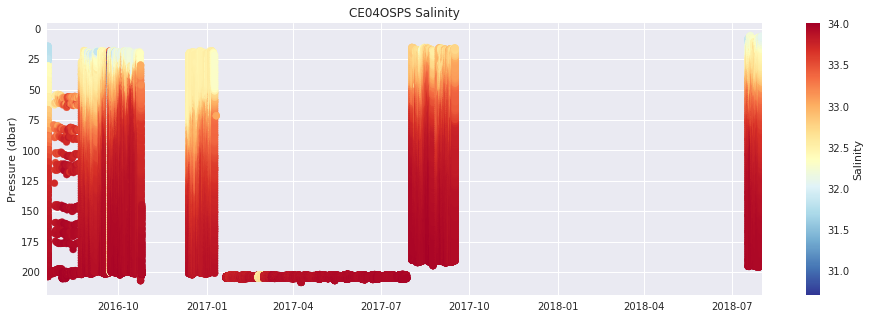

In [78]:
# Scatterplot of Sal
fig,ax1 = plt.subplots(1,1,figsize=(16,5))
sc1 = ax1.scatter(dtime, pressure, c=salinity, cmap='RdYlBu_r') # Add s=2 to set the markersize
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Salinity')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('CE04OSPS Salinity');

plt.savefig('CE04OSPS_sal.png');

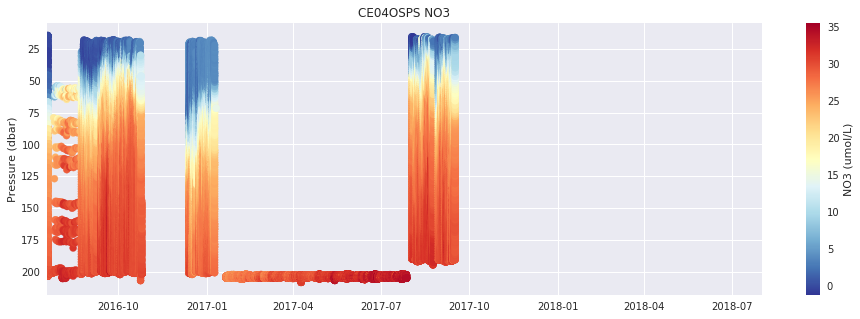

In [79]:
# Scatterplot of NO3
fig,ax1 = plt.subplots(1,1,figsize=(16,5))
sc1 = ax1.scatter(dtime, pressure, c=no3, cmap='RdYlBu_r') # Add s=2 to set the markersize
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('NO3 (umol/L)')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('CE04OSPS NO3');

plt.savefig('CE04OSPS_NO3.png');

### Summary - CE04OSPS
Generally the NO3 profiles at CE04OSPS look OK. The intrusions into deeper water match up with temperature/ salinity profiles. The range of values (~0-40 uM) and direction of profiles (nutrient-rich deeper water and nutrient-deplete surface water) makes sense.

**Three major issues with CE04OSPS Profiler Nutrient Data:**  
1- In early 2016, the profilers are missing several depths for several weeks. This occurred at the instrument level? (both temperature and NO3 are affected). This is not annotated.  
2- The most recent data for 2018 is posted for temperature, salinity but not NO3. Spoke to Sage, this may be an input error in the name of the most recent instrument asset.  
3- There is an error in the "deployment 002" file. Looked through .nc file in panoply with Lori. There is no "coordinates" attribute whereas the other deployments have "time lat lon int_ctd_pressure" in coordinates attribute so open_mfdataset could not match the datasets. For this analysis, I did not include that deployment. Lori has started a ticket about this for another dataset. This dataset should be added to that ticket.

### **B) Oregon Slope Base Shallow Profiler Mooring (RS01SBPS)**
RS01SBPS-SF01A-4A-NUTNRA101  
5 to 200 meters  
Shallow Profiler (SF01A)  
Nitrate (NUTNRA)  
Satlantic - Deep SUNA 

In [3]:
# Instrument Information 
# RS01SBPS-SF01A-4A-NUTNRA101  

site = 'RS01SBPS'
node = 'SF01A'
instrument = '4A-NUTNRA101'
method = 'streamed'
stream = 'nutnr_a_sample'

VOCAB_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
request_url ='/'.join((VOCAB_BASE_URL,site,node,instrument)) # Python wizard best

# Retrieve vocabulary information for a given instrument
r = requests.get(request_url, auth=(USERNAME, TOKEN))
data = r.json() #this converts from json back to python array
data

[{'@class': '.VocabRecord',
  'model': 'Deep SUNA',
  'manufacturer': 'Satlantic',
  'vocabId': 1339,
  'refdes': 'RS01SBPS-SF01A-4A-NUTNRA101',
  'instrument': 'Nitrate',
  'tocL1': 'Cabled Continental Margin',
  'tocL2': 'Oregon Slope Base Shallow Profiler Mooring',
  'tocL3': 'Shallow Profiler (SF01A)',
  'mindepth': 5.0,
  'maxdepth': 200.0}]

### Data Requests:

In [4]:
# API base url
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Create the request URL- similar to above
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# All of the following are optional but if you don't specify dates, you will get entire datasets. For some sets, this is enormous.- Include parameters- Last 2 lines are optional
params = {
  'beginDT':'2013-01-01T00:00:00.000Z',
  'endDT':'2018-08-10T00:00:00.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}


In [5]:
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()
# print(data['allURLs'][0])

In [6]:
url ='https://opendap.oceanobservatories.org/thredds/catalog/ooi/elizabeth.suter@wagner.edu/20180801T205733-RS01SBPS-SF01A-4A-NUTNRA101-streamed-nutnr_a_sample/catalog.html'

In [7]:
# Use to monitor data download- Comment out when not downloading data
# check_complete = data['allURLs'][1] + '/status.txt'
# for i in range(1800):
#     r = requests.get(check_complete)
#     if r.status_code == requests.codes.ok:
#         print('request completed')
#         break
#     else:
#             time.sleep(1)

In [8]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
# datasets

In [9]:
# Create a list of only the NUTNR files 
# (exclude files from CTD that might also be provided in the data request)
datasets_sel = []
for i in datasets:
    if '2A-CTDPFA102' in i:
        pass
    else:
        datasets_sel.append(i)
# datasets_sel

In [10]:
# Load the data files
ds = xr.open_mfdataset(datasets_sel[0:5])
# ds

# THERE IS ANOTHER ERROR IN INDEXING HERE. Deployment 0001 has incorrect attributes in its coordinates again!

### Check annotations

In [11]:
# Specify a reference designator
refdes = 'RS01SBPS-SF01A-4A-NUTNRA101'

begin = int(datetime.date(2013,1,1).strftime('%s'))*1000
end = int(datetime.datetime.now().strftime("%s")) * 1000 # current date

In [12]:
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT': begin,
  'endDT': end,
  'refdes': refdes,
}

# Send the request
r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

# Also make a pandas variable from annotation data so for use later in plotting
anno_data = pd.read_json(json.dumps(r.json())) # convert json response to pandas dataframe

In [14]:
# convert timestamps to readable
def convert_time(ms):
    if ms != None:
        return datetime.datetime.utcfromtimestamp(ms/1000)
    else:
        return None

In [15]:
# Look at contents of first point
data[0]

{'@class': '.AnnotationRecord',
 'annotation': 'SF01A powered down on 3/21/2018 due to oil leak. (Redmine #13323). Instruments on profiler turned on 2018-06-24.',
 'method': None,
 'id': 1369,
 'source': 'friedrich.knuth@rutgers.edu',
 'node': 'SF01A',
 'parameters': [],
 'stream': None,
 'subsite': 'RS01SBPS',
 'sensor': None,
 'beginDT': 1521591180000,
 'endDT': 1529836802667,
 'exclusionFlag': False,
 'qcFlag': 'not_operational'}

In [16]:
# Convert info the json response to a dataframe for easier visualization
df = pd.DataFrame() # Setup empty array
for d in data:
    df = df.append({
        'annotation_id': d['id'],
        'subsite': d['subsite'],
        'node': d['node'],
        'sensor': d['sensor'],
        'stream': d['stream'],
        'method': d['method'],
        'start': convert_time(d['beginDT']),
        'stop': convert_time(d['endDT']),
        'qcFlag': d['qcFlag'],
        'annotation': d['annotation']
    }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df.head()
# view annotation in human readable. These are listed in no particular order. Look at all levels for annotations (node, sensor, stream, subsite, etc)

,annotation,annotation_id,method,node,qcFlag,sensor,start,stop,stream,subsite
0,SF01A powered down on 3/21/2018 due to oil leak. (Redmine #13323). Instruments on profiler turned on 2018-06-24.,1369.0,None,SF01A,not_operational,None,2018-03-21 00:13:00.000,2018-06-24 10:40:02.667,None,RS01SBPS
1,A brief violent storm caused loss of power to both the North and South cable lines and the deployed infrastructure during this time. For more information please contact help@oceanobservatories.org. (Redmine # 13109),319.0,None,None,not_operational,None,2018-01-19 03:00:01.000,2018-01-19 19:00:01.000,None,RS01SBPS
2,This instrument was deployed with onboard processing set to freshwater mode leading to an invalid L1 Dissolved Nitrate Concentration data product. The L2 version of the data product is unaffected by that onboard setting as it is calculated using the L0 data with salinity and temperature from a co-located CTD. Redmine: 8659,1370.0,streamed,SF01A,suspect,4A-NUTNRA101,2015-07-08 22:22:01.974,2016-02-05 02:00:11.695,nutnr_a_sample,RS01SBPS
3,"Note: PFE down. HVPS1 MOV explosion, 800A breaker tripped, investigation and restoration",1248.0,None,None,None,None,2014-12-07 19:45:00.000,2014-12-16 00:00:00.000,None,RS01SBPS
4,Note: PNWGP Portland <-> Seattle outage. Possible data gap < 24h.,1250.0,None,None,None,None,2015-01-07 07:32:00.000,2015-01-07 08:06:00.000,None,RS01SBPS


In [17]:
# Write annotations to a csv file in working directory
df.to_csv('{}_annotations.csv'.format(refdes), index=False)
# exports annotations as csv. Shows up in working directory

Print the annotations and check against plot

In [18]:
for i in range(len((anno_data['annotation'].values))):
    print(i)
    print(anno_data['annotation'].iloc[i])
    print('start time:', anno_data['beginDT'].iloc[i])
    print('end time:', anno_data['endDT'].iloc[i],'\n')

0
SF01A powered down on 3/21/2018 due to oil leak. (Redmine #13323). Instruments on profiler turned on 2018-06-24.
start time: 1521591180000
end time: 1529836802667 

1
A brief violent storm caused loss of power to both the North and South cable lines and the deployed infrastructure during this time. For more information please contact help@oceanobservatories.org. (Redmine # 13109)
start time: 1516330801000
end time: 1516388401000 

2
This instrument was deployed with onboard processing set to freshwater mode leading to an invalid L1 Dissolved Nitrate Concentration data product. The L2 version of the data product is unaffected by that onboard setting as it is calculated using the L0 data with salinity and temperature from a co-located CTD. Redmine: 8659
start time: 1436394121974
end time: 1454637611695 

3
Note: PFE down. HVPS1 MOV explosion, 800A breaker tripped, investigation and restoration
start time: 1417981500000
end time: 1418688000000 

4
Note: PNWGP Portland <-> Seattle outage

## Plot Timeseries of NO3

In [ ]:
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds = ds.swap_dims({'obs': 'time'}) 

# Sort the data
ds = ds.sortby('time'); 

# Optional, this is used to optimize data processing
ds = ds.chunk({'time': 100}) 

# ds

In [21]:
# Extract the values individually so you can crete multi-D scatter plots
dtime = ds['time'].values
pressure = ds['int_ctd_pressure'].values
temperature = ds['seawater_temperature'].values
salinity = ds['practical_salinity'].values
no3 = ds['salinity_corrected_nitrate'].values

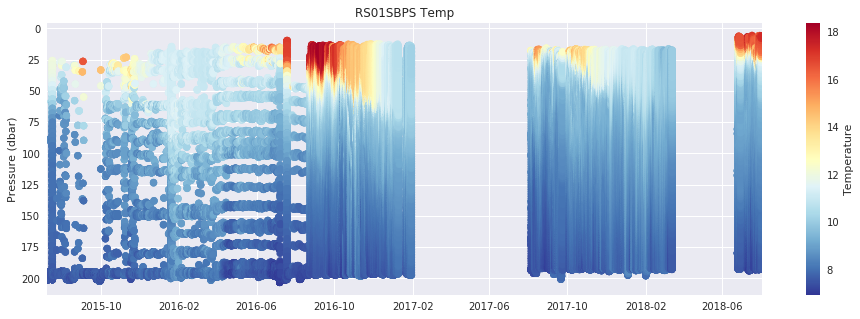

In [22]:
# Scatterplot of Temp
fig,ax1 = plt.subplots(1,1,figsize=(16,5))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap='RdYlBu_r') # Add s=2 to set the markersize
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('RS01SBPS Temp');

plt.savefig('RS01SBPS_temp.png');

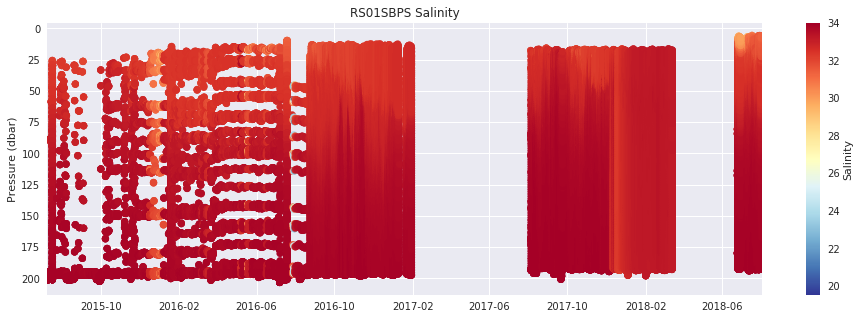

In [23]:
# Scatterplot of Temp
fig,ax1 = plt.subplots(1,1,figsize=(16,5))
sc1 = ax1.scatter(dtime, pressure, c=salinity, cmap='RdYlBu_r') # Add s=2 to set the markersize
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Salinity')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('RS01SBPS Salinity');

plt.savefig('RS01SBPS_salinity.png');

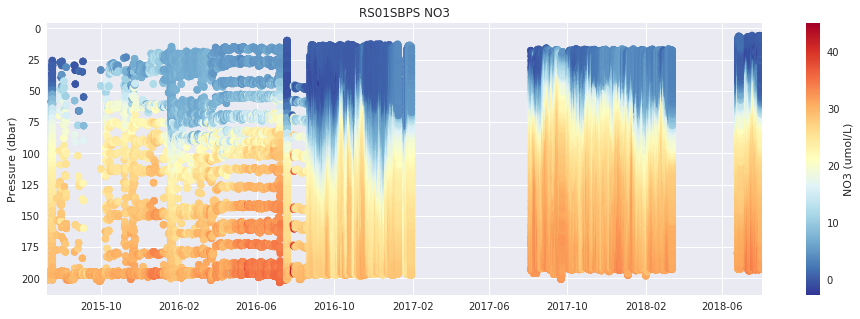

In [24]:
# Scatterplot of NO3
fig,ax1 = plt.subplots(1,1,figsize=(16,5))
sc1 = ax1.scatter(dtime, pressure, c=no3, cmap='RdYlBu_r') # Add s=2 to set the markersize
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('NO3 (umol/L)')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('RS01SBPS NO3');

plt.savefig('RS01SBPS_NO3.png');

### Summary - RS01SBPS
Generally the NO3 profiles at RS01SBPS look reasonable. The direction of patterns and range of values are reasonable. 

There is a period when cold, fresher water is present in the surface but NO3 is depleted. This may be due to a rapidly forming phytoplankton bloom. Try look at plankton proxies.

**Major issues with RS01SBPS Profiler Nutrient Date:**  
1-  The annotation from 7/8/15 to 2/5/16 flags suspect data that was collected in "Freshwater mode" that messed up the Level 1 calculation. But the annotation also claims "The L2 version of the data product is unaffected by that onboard setting" because it used CTD data to make the calculation. I disagree. There is a big jump in values before/ after this region and the L2 data are clearly affected.  
2- In Jul/ Aug 2016 there is another jump in values to a new baseline. Happens in temp data too.  
3- There is an error in the "deployment 001" file. There is no "coordinates" attribute again. Skipped that deplyment for now.

### **C) Oregon Slope Base Shallow Profiler Mooring (RS03AXPS)**
RS03AXPS-SF03A-4A-NUTNRA301 
5 to 200 meters  
Shallow Profiler (SF03A)  
Nitrate (NUTNRA)  
Satlantic - Deep SUNA  


In [25]:
# Instrument Information 
# RS03AXPS-SF03A-4A-NUTNRA301

site = 'RS03AXPS'
node = 'SF03A'
instrument = '4A-NUTNRA301'
method = 'streamed'
stream = 'nutnr_a_sample'

VOCAB_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
request_url ='/'.join((VOCAB_BASE_URL,site,node,instrument)) # Python wizard best

# Retrieve vocabulary information for a given instrument
r = requests.get(request_url, auth=(USERNAME, TOKEN))
data = r.json() #this converts from json back to python array
data

[{'@class': '.VocabRecord',
  'model': 'Deep SUNA',
  'manufacturer': 'Satlantic',
  'vocabId': 1434,
  'refdes': 'RS03AXPS-SF03A-4A-NUTNRA301',
  'instrument': 'Nitrate',
  'tocL1': 'Cabled Axial Seamount',
  'tocL2': 'Axial Base Shallow Profiler Mooring',
  'tocL3': 'Shallow Profiler (SF03A)',
  'mindepth': 5.0,
  'maxdepth': 200.0}]

### Data Requests:

In [26]:
# API base url
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Create the request URL- similar to above
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# All of the following are optional but if you don't specify dates, you will get entire datasets. For some sets, this is enormous.- Include parameters- Last 2 lines are optional
params = {
  'beginDT':'2013-01-01T00:00:00.000Z',
  'endDT':'2018-08-10T00:00:00.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}

In [27]:
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()
# print(data['allURLs'][0])

In [28]:
url ='https://opendap.oceanobservatories.org/thredds/catalog/ooi/elizabeth.suter@wagner.edu/20180802T204901-RS03AXPS-SF03A-4A-NUTNRA301-streamed-nutnr_a_sample/catalog.html'

In [29]:
# # Use to monitor data download- Comment out when not downloading data
# check_complete = data['allURLs'][1] + '/status.txt'
# for i in range(1800):
#     r = requests.get(check_complete)
#     if r.status_code == requests.codes.ok:
#         print('request completed')
#         break
#     else:
#             time.sleep(1)

In [30]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
# datasets

In [31]:
# Create a list of only the NUTNR files 
# (exclude files from CTD that might also be provided in the data request)
datasets_sel = []
for i in datasets:
    if '2A-CTDPFA302' in i:
        pass
    else:
        datasets_sel.append(i)
#datasets_sel

In [ ]:
# Load the data files
ds = xr.open_mfdataset(datasets_sel[0:2])
#ds

# THERE IS ANOTHER ERROR IN INDEXING HERE. Deployments 0001 and 002 don't merge

### Check annotations

In [33]:
# Specify a reference designator
refdes = 'RS03AXPS-SF03A-4A-NUTNRA301'

# if you want all annotations, use these dates
begin = int(datetime.date(2013,1,1).strftime('%s'))*1000
end = int(datetime.datetime.now().strftime("%s")) * 1000 # current date

In [34]:
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT': begin,
  'endDT': end,
  'refdes': refdes,
}

# Send the request
r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

# Also make a pandas variable from annotation data so for use later in plotting
anno_data = pd.read_json(json.dumps(r.json())) # convert json response to pandas dataframe

In [35]:
# convert timestamps to readable
def convert_time(ms):
    if ms != None:
        return datetime.datetime.utcfromtimestamp(ms/1000)
    else:
        return None

In [36]:
# Look at contents of first point
data[0]

{'@class': '.AnnotationRecord',
 'annotation': 'A brief violent storm caused loss of power to both the North and South cable lines and the deployed infrastructure during this time. For more information please contact help@oceanobservatories.org. (Redmine # 13109)',
 'method': None,
 'id': 329,
 'source': 'friedrich.knuth@rutgers.edu',
 'node': None,
 'parameters': [],
 'stream': None,
 'subsite': 'RS03AXPS',
 'sensor': None,
 'beginDT': 1516330801000,
 'endDT': 1516388401000,
 'exclusionFlag': False,
 'qcFlag': 'not_operational'}

In [100]:
# Write annotations to a csv file in working directory
df.to_csv('{}_annotations.csv'.format(refdes), index=False)
# exports annotations as csv. Shows up in working directory

In [37]:
# Convert info the json response to a dataframe for easier visualization
df = pd.DataFrame() # Setup empty array
for d in data:
    df = df.append({
        'annotation_id': d['id'],
        'subsite': d['subsite'],
        'node': d['node'],
        'sensor': d['sensor'],
        'stream': d['stream'],
        'method': d['method'],
        'start': convert_time(d['beginDT']),
        'stop': convert_time(d['endDT']),
        'qcFlag': d['qcFlag'],
        'annotation': d['annotation']
    }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df.head()
# view annotation in human readable. These are listed in no particular order. Look at all levels for annotations (node, sensor, stream, subsite, etc)

,annotation,annotation_id,method,node,qcFlag,sensor,start,stop,stream,subsite
0,A brief violent storm caused loss of power to both the North and South cable lines and the deployed infrastructure during this time. For more information please contact help@oceanobservatories.org. (Redmine # 13109),329.0,None,None,not_operational,None,2018-01-19 03:00:01,2018-01-19 19:00:01,None,RS03AXPS
1,"Note: PFE down. HVPS1 MOV explosion, 800A breaker tripped, investigation and restoration",1296.0,None,None,None,None,2014-12-07 19:45:00,2014-12-16 00:00:00,None,RS03AXPS
2,Note: PNWGP Portland <-> Seattle outage,1299.0,None,None,None,None,2015-01-07 07:32:00,2015-01-07 08:06:00,None,RS03AXPS
3,Note: Intermittent partial data loss due to storage drive problems at OTB,1300.0,None,None,None,None,2015-01-31 00:00:00,2015-02-04 00:00:00,None,RS03AXPS
4,Note: PNWGP outage due to City of Seattle fiber cable work,1306.0,None,None,None,None,2015-03-21 14:10:00,2015-03-22 04:20:00,None,RS03AXPS


In [38]:
# Write annotations to a csv file in working directory
df.to_csv('{}_annotations.csv'.format(refdes), index=False)
# exports annotations as csv. Shows up in working directory

In [39]:
for i in range(len((anno_data['annotation'].values))):
    print(i)
    print(anno_data['annotation'].iloc[i])
    print('start time:', anno_data['beginDT'].iloc[i])
    print('end time:', anno_data['endDT'].iloc[i],'\n')

0
A brief violent storm caused loss of power to both the North and South cable lines and the deployed infrastructure during this time. For more information please contact help@oceanobservatories.org. (Redmine # 13109)
start time: 1516330801000
end time: 1516388401000 

1
Note: PFE down. HVPS1 MOV explosion, 800A breaker tripped, investigation and restoration
start time: 1417981500000
end time: 1418688000000 

2
Note: PNWGP Portland <-> Seattle outage
start time: 1420615920000
end time: 1420617960000 

3
Note: Intermittent partial data loss due to storage drive problems at OTB
start time: 1422662400000
end time: 1423008000000 

4
Note: PNWGP outage due to City of Seattle fiber cable work
start time: 1426947000000
end time: 1426998000000 

5
Note: Network issues due to fire that damaged fibers between Portland and Seattle
start time: 1434153600000
end time: 1434385800000 

6
Note: Outage during major utility power failure in Seattle
start time: 1440806400000
end time: 1440808200000 

7
N

### Plot Timeseries of NO3

In [40]:
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds = ds.swap_dims({'obs': 'time'}) 

# Sort the data
ds = ds.sortby('time'); 

# Optional, this is used to optimize data processing
ds = ds.chunk({'time': 100}) 

#ds

In [41]:
# Extract the values individually so you can crete multi-D scatter plots
dtime = ds['time'].values
pressure = ds['int_ctd_pressure'].values
temperature = ds['seawater_temperature'].values
salinity = ds['practical_salinity'].values
no3 = ds['salinity_corrected_nitrate'].values

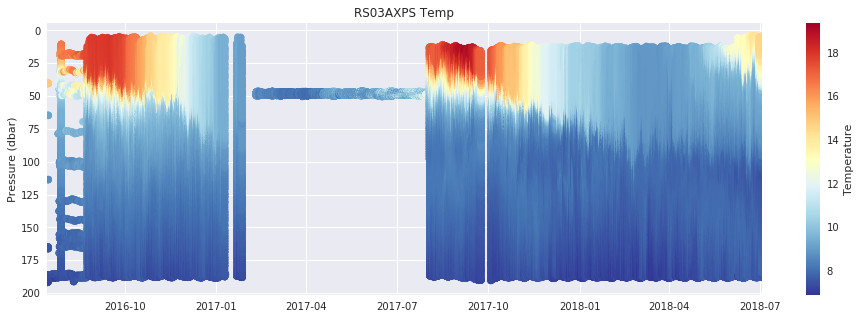

In [42]:
# Scatterplot of Temp
fig,ax1 = plt.subplots(1,1,figsize=(16,5))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap='RdYlBu_r') # Add s=2 to set the markersize
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('RS03AXPS Temp');

plt.savefig('RS03AXPS_temp.png');

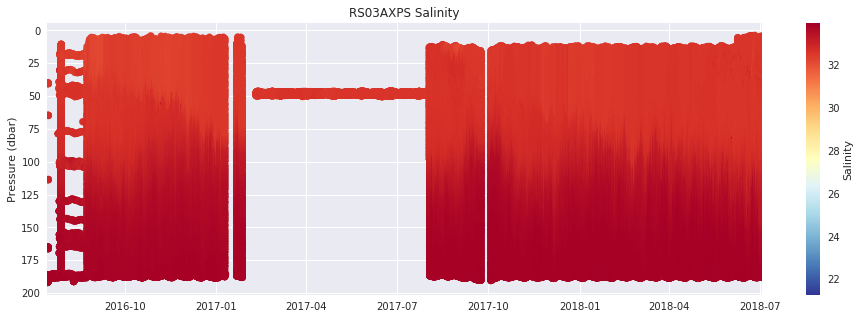

In [43]:
# Scatterplot of Salinity
fig,ax1 = plt.subplots(1,1,figsize=(16,5))
sc1 = ax1.scatter(dtime, pressure, c=salinity, cmap='RdYlBu_r') # Add s=2 to set the markersize
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Salinity')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('RS03AXPS Salinity');

plt.savefig('RS03AXPS_salinity.png');

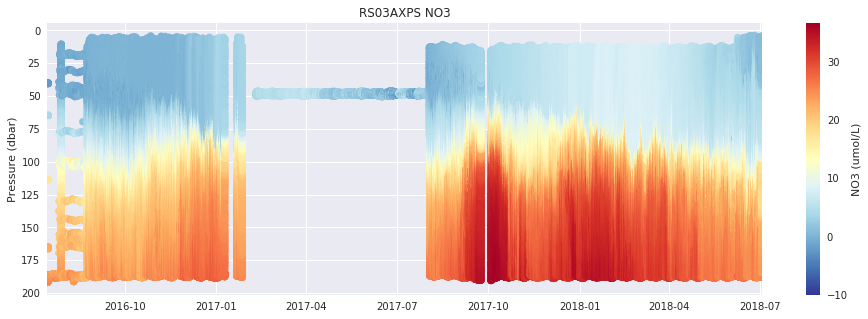

In [44]:
# Scatterplot of NO3
fig,ax1 = plt.subplots(1,1,figsize=(16,5))
sc1 = ax1.scatter(dtime, pressure, c=no3, cmap='RdYlBu_r') # Add s=2 to set the markersize
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('NO3 (umol/L)')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('RS03AXPS NO3');

plt.savefig('RS03AXPS_NO3.png');

### Summary - RS03AXPS
Generally the NO3 profiles at RS03AXPS look reasonable, similar to profiles from other sites you can see the thermocline and nutricline exhibit similar structures in time. Transitions between deployments seem smoother than for previous sites.


**Major issues with RS03AXPS Profiler Nutrient Data:**  
1-  Similar to  profiles above, there are depth jumps in the profiles in 2016 that are not annotated.
2-  There is another errors in the coordinates varible for deployments 1 and 2 so they don't easily merge with the other deployment datasets.


Interestingly, you can see the shoaling and deepening of the nutricline with upwelling. But still, the nutrient concentrations above the mixed layer remain depleted throughout this time series. I wonder if this can be explained by phytoplankton activity. 

## **3- Comparison of Phytoplankton Proxies and Nitrate Data**

### **First Attempt**- Check out beam attenuation and optical absorbance from concurrent OPTAA sensors from RS01SBPS

In [45]:
# Instrument Information 
# RS01SBPS-SF01A-3B-OPTAAD101

site = 'RS01SBPS'
node = 'SF01A'
instrument = '3B-OPTAAD101'
method = 'streamed'
stream = 'optaa_sample'

# API base url
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Create the request URL- similar to above
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# All of the following are optional but if you don't specify dates, you will get entire datasets. For some sets, this is enormous.- Include parameters- Last 2 lines are optional
params = {
  'beginDT':'2013-01-01T00:00:00.000Z',
  'endDT':'2018-08-10T00:00:00.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}


In [46]:
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()
# print(data['allURLs'][0])

In [47]:
url ='https://opendap.oceanobservatories.org/thredds/catalog/ooi/elizabeth.suter@wagner.edu/20180802T143951-RS01SBPS-SF01A-3B-OPTAAD101-streamed-optaa_sample/catalog.html'

In [48]:
# # Use to monitor data download- Comment out when not downloading data
# check_complete = data['allURLs'][1] + '/status.txt'
# for i in range(1800):
#     r = requests.get(check_complete)
#     if r.status_code == requests.codes.ok:
#         print('request completed')
#         break
#     else:
#             time.sleep(1)

# Took forever to download. OPTAA files are large. Also deployments are split into multiple files

In [49]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
#datasets


In [50]:
# These OPTAA files are way too look at all. For this workshop, I will only focus on the most recent 2 deployments, 
# which has decent NO3 data, so that I can compare.
# Dates ate 6/24/18 until today

datasets_sel = ['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/elizabeth.suter@wagner.edu/20180802T143951-RS01SBPS-SF01A-3B-OPTAAD101-streamed-optaa_sample/deployment0006_RS01SBPS-SF01A-3B-OPTAAD101-streamed-optaa_sample_20180722T204215.944323-20180802T082505.325348.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/elizabeth.suter@wagner.edu/20180802T143951-RS01SBPS-SF01A-3B-OPTAAD101-streamed-optaa_sample/deployment0006_RS01SBPS-SF01A-3B-OPTAAD101-streamed-optaa_sample_20180710T170047.735357-20180722T082504.157856.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/elizabeth.suter@wagner.edu/20180802T143951-RS01SBPS-SF01A-3B-OPTAAD101-streamed-optaa_sample/deployment0005_RS01SBPS-SF01A-3B-OPTAAD101-streamed-optaa_sample_20180705T204214.777659-20180708T214501.012860.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/elizabeth.suter@wagner.edu/20180802T143951-RS01SBPS-SF01A-3B-OPTAAD101-streamed-optaa_sample/deployment0005_RS01SBPS-SF01A-3B-OPTAAD101-streamed-optaa_sample_20180624T165014.753764-20180705T082501.462673.nc',]


In [15]:
ds1 = xr.open_dataset(datasets_sel[0])
ds2 = xr.open_dataset(datasets_sel[1])
ds3 = xr.open_dataset(datasets_sel[2])
ds4 = xr.open_dataset(datasets_sel[3])

In [ ]:
ds1

In [17]:
ds1 = ds1.swap_dims({'obs': 'time'})
ds2 = ds2.swap_dims({'obs': 'time'})
ds3 = ds3.swap_dims({'obs': 'time'})
ds4 = ds4.swap_dims({'obs': 'time'})

In [18]:
# I know it's smarter to do this in a loop but I am running out of patience/ time!

time1 = ds1['time'][0::1000].data
pressure1 = ds1['int_ctd_pressure'][0::1000].data
# bat1 = ds1['beam_attenuation'][0::1000].data
abs1 = ds1['optical_absorption'][0::1000].data

# time2 = ds2['time'][0::1000].data
# pressure2 = ds2['int_ctd_pressure'][0::1000].data
# bat2 = ds2['beam_attenuation'][0::1000].data
# abs2 = ds2['optical_absorption'][0::1000].data

# time3 = ds3['time'][0::1000]
# pressure3 = ds3['int_ctd_pressure'][0::1000]
# bat3 = ds3['beam_attenuation'][0::1000]
# abs3 = ds3['optical_absorption'][0::1000]

# time4 = ds4['time'][0::1000]
# pressure4 = ds4['int_ctd_pressure'][0::1000]
# bat4 = ds4['beam_attenuation'][0::1000]
# abs4 = ds4['optical_absorption'][0::1000]

In [21]:
print(time1.shape)
print(pressure1.shape)
print(abs1.shape)

(305,)
(305,)
(305, 83)


At this point I realized that the optical_absoprtion and beam attenuation datasets are not one parameter per depth but are >80 columns of data (each with absorbance/ attenuation over a wavelength bin).

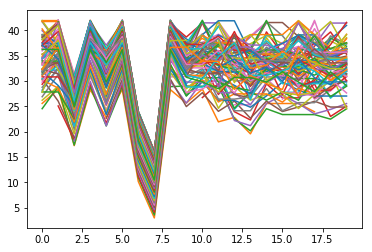

In [80]:
fig = plt.plot(abs1[5:25])
               #linestyle='None',marker='.',markersize=1)
# ax1.invert_yaxis()
#plt.savefig('RS01SBPS_some_opt_abs_spectra_deployment6.png');

### **Summary - OPTAA Phytoplankton Parameters**
These data were generally unuseable to me. It took a long time to just download and subsample a limited time window of data and then I was not able to wrangle these results further into something that made sense biologically.

Sage shared the OPTAA script with me and I may be able to use that in the future.

My very humble suggestion would be to take a look at what Seabird does for their beam attenuation calculations, for example. Their software produces beam attenuation profiles that indicate suspended particulates and we have always found them a good proxy for total cell abundance (measured independently by microscopy).


### **Second Attempt**- Check out fluorometer data from RS03AXPS

In [66]:
# Instrument Information 
# RS03AXPS-PC03A-4C-FLORDD303

site = 'RS03AXPS'
node = 'PC03A'
instrument = '4C-FLORDD303'
method = 'streamed'
stream = 'flort_d_data_record'

VOCAB_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
request_url ='/'.join((VOCAB_BASE_URL,site,node,instrument)) # Python wizard best

# Retrieve vocabulary information for a given instrument
r = requests.get(request_url, auth=(USERNAME, TOKEN))
data = r.json() #this converts from json back to python array
data

[{'@class': '.VocabRecord',
  'model': 'ECO Triplet-w',
  'manufacturer': 'WET Labs',
  'vocabId': 1424,
  'refdes': 'RS03AXPS-PC03A-4C-FLORDD303',
  'instrument': '2-Wavelength Fluorometer',
  'tocL1': 'Cabled Axial Seamount',
  'tocL2': 'Axial Base Shallow Profiler Mooring',
  'tocL3': '200m Platform (PC03A)',
  'mindepth': 200.0,
  'maxdepth': 200.0}]

**NOTE** It is not immediatly obvious from web that these data were from a single depth since they are on a profiler. Up to this point, I thought I would get profiled data

### Data Requests:

In [52]:
# API base url
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Create the request URL- similar to above
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# All of the following are optional but if you don't specify dates, you will get entire datasets. For some sets, this is enormous.- Include parameters- Last 2 lines are optional
params = {
  'beginDT':'2013-01-01T00:00:00.000Z',
  'endDT':'2018-08-10T00:00:00.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}

In [53]:
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()
# print(data['allURLs'][0])

In [54]:
url ='https://opendap.oceanobservatories.org/thredds/catalog/ooi/elizabeth.suter@wagner.edu/20180803T133041-RS03AXPS-PC03A-4C-FLORDD303-streamed-flort_d_data_record/catalog.html'

In [55]:
# # Use to monitor data download- Comment out when not downloading data
# check_complete = data['allURLs'][1] + '/status.txt'
# for i in range(1800):
#     r = requests.get(check_complete)
#     if r.status_code == requests.codes.ok:
#         print('request completed')
#         break
#     else:
#             time.sleep(1)

In [56]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
# datasets

In [58]:
# Create a list of only the FLOR files 
# (exclude files from CTD that might also be provided in the data request)
datasets_sel = []
for i in datasets:
    if '2A-CTDPFA302' in i:
        pass
    else:
        datasets_sel.append(i)
#datasets_sel


In [60]:
# Load the data files
ds = xr.open_dataset(datasets_sel[1])
# ds

# Problem merging due to coordinates mismatch again

# Grabbed just one file:
# fluor data correpsonds to 20171121 to 20180322
# grabbed nutnr file that is from 20170802 to 20180702 in order to match as best as possible

In [61]:
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds = ds.swap_dims({'obs': 'time'}) 

# # Sort the data
# ds = ds.sortby('time'); 

# # Optional, this is used to optimize data processing
# ds = ds.chunk({'time': 100}) 


### Plot Timeseries of Flor

In [ ]:
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds = ds.swap_dims({'obs': 'time'}) 

# # Sort the data
# ds = ds.sortby('time'); 

# # Optional, this is used to optimize data processing
# ds = ds.chunk({'time': 100}) 

#ds

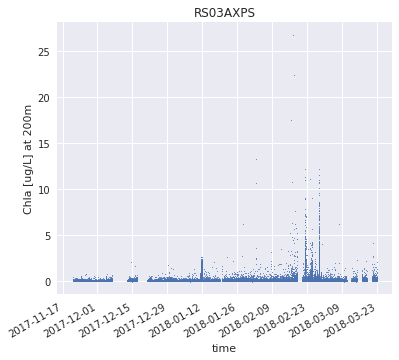

In [83]:
# Scatterplot?
fig,ax1 = plt.subplots(1,1,figsize=(6,5))
ds['fluorometric_chlorophyll_a'].plot(ax=ax1,label='Raw',linestyle='None',marker='.',markersize=2)
ax1.set_ylabel('Chla [ug/L] at 200m')
ax1.set_title('RS03AXPS');


plt.savefig('RS03AXPS_flor.png');

### Plot Timeseries of NO3 over similar period

In [75]:
# Instrument Information 
# RS03AXPS-SF03A-4A-NUTNRA301
# NOTE- already requested these data above

site = 'RS03AXPS'
node = 'SF03A'
instrument = '4A-NUTNRA301'
method = 'streamed'
stream = 'nutnr_a_sample'

url ='https://opendap.oceanobservatories.org/thredds/catalog/ooi/elizabeth.suter@wagner.edu/20180802T204901-RS03AXPS-SF03A-4A-NUTNRA301-streamed-nutnr_a_sample/catalog.html'

In [76]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]

datasets_sel = []
for i in datasets:
    if '2A-CTDPFA302' in i:
        pass
    else:
        datasets_sel.append(i)
datasets_sel

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/elizabeth.suter@wagner.edu/20180802T204901-RS03AXPS-SF03A-4A-NUTNRA301-streamed-nutnr_a_sample/deployment0004_RS03AXPS-SF03A-4A-NUTNRA301-streamed-nutnr_a_sample_20170802T213237.171288-20180702T195541.027800.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/elizabeth.suter@wagner.edu/20180802T204901-RS03AXPS-SF03A-4A-NUTNRA301-streamed-nutnr_a_sample/deployment0003_RS03AXPS-SF03A-4A-NUTNRA301-streamed-nutnr_a_sample_20160714T233012.596032-20170730T130004.801532.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/elizabeth.suter@wagner.edu/20180802T204901-RS03AXPS-SF03A-4A-NUTNRA301-streamed-nutnr_a_sample/deployment0002_RS03AXPS-SF03A-4A-NUTNRA301-streamed-nutnr_a_sample_20150710T205952.189176-20160707T055025.135078.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/elizabeth.suter@wagner.edu/20180802T204901-RS03AXPS-SF03A-4A-NUTNRA301-streamed-nutnr_a_sample/deployment0001_RS03AXPS-SF03A-

In [77]:
# Only pick file with desired time range
ds_nutnr = xr.open_dataset(datasets_sel[0])
# ds_nutnr

In [78]:
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds_nutnr = ds_nutnr.swap_dims({'obs': 'time'}) 

In [80]:
# Try to merge the two datasets
# ds.merge(ds_nutnr)
# xr.merge([ds, ds_nutnr])

# Never could get this to work. Maybe because I don't know enough about xarray

In [81]:
# Extract the values individually so you can crete multi-D scatter plots
dtime = ds_nutnr['time'].values
pressure = ds_nutnr['int_ctd_pressure'].values
temperature = ds_nutnr['seawater_temperature'].values
#salinity = ds_nutnr['practical_salinity'].values
no3 = ds_nutnr['salinity_corrected_nitrate'].values

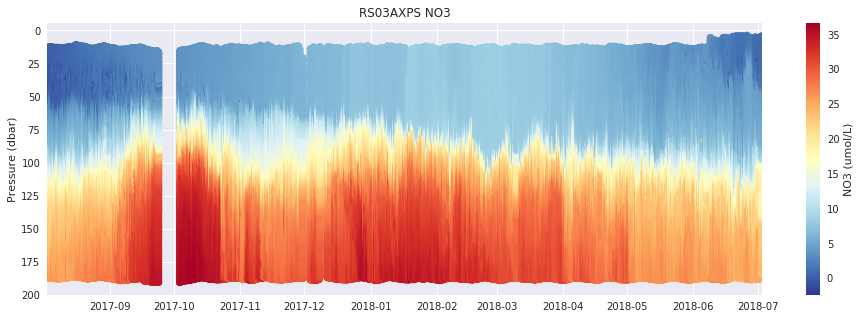

In [84]:
# Scatterplot of NO3
fig,ax1 = plt.subplots(1,1,figsize=(16,5))
sc1 = ax1.scatter(dtime, pressure, c=no3, cmap='RdYlBu_r') # Add s=2 to set the markersize
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('NO3 (umol/L)')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('RS03AXPS NO3');

plt.savefig('RS03AXPS_NO3_subset.png');

### **Summary - Florometer data at RS03AXPS**
The florometer at this station at 200m actually indicates a deep phytoplankton bloom in late Feb/ early March 2018. This corresponds to a deepening of the nutricline and an overall drawdown of total NO3 concentrations. This makes a lot of biological sense. Cool!

## **Overall Conclusions**


Other than specific comments on aspects of the datasets I examined above, here are some general conclusions:
* The ISUS sensors are clearly not as good as the SUNA sensors but in terms of day-to-day variability, may have detected some real signals in variation. This is difficult to cross-validate without bottle data but NO3 concentrations can naturally exhibit large fluctuations in surface waters. The variation in ISUS sensors was not that different from that of the SUNA sensors.
* Generally, the SUNA sensors from the profilers generate reasonable datasets. Coverage is getting better with time.
* Data from the 3 deep SUNA sensors largely align with phyical data. Awesome!
* It is difficult to cross-validate depth profiles of NO3 data with any proxies for plankton. I would have loved to compare to profiles of beam attenuation, optical absorbance, or floromter data but was unable to do so.
    * The fluorometer data at 200m correpsonds well to NO3 drawdown at that time. But this is already very deep for looking at phytoplankton variables. A profile would be helpful.
* Thank you guys for letting me have this opportunity! will definitely be using this as a resource!